In [8]:
from keras.models import load_model
import cv2
from keras import backend as K
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np
from keras import layers, models
from keras.utils import CustomObjectScope
from keras.initializers import glorot_uniform
import os
import pandas as pd
import numpy as np

In [2]:
os.chdir('/Users/RHedg/DATA 2040')
with CustomObjectScope({'GlorotUniform': glorot_uniform()}):
        model = load_model('best_model.h5')

C:\Users\RHedg\.conda\envs\opencv\lib\site-packages\keras\engine\saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [270]:
os.chdir('/Users/RHedg/SFL Scientific Capstone/images/celeba')
image_name = '183976.jpg'

img = image.load_img(image_name, target_size=(218, 178))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0) # add dimension to be able to fit into model
x = preprocess_input(x) # channel-wise color normalization

In [271]:
attractive_output = model.output[:, 0]

last_conv_layer = model.get_layer('conv2d_48')

grads = K.gradients(attractive_output, last_conv_layer.output)[0] # gradients of class with regard to output of feature map

pooled_grads = K.mean(grads, axis=(0, 1, 2))

iterate = K.function([model.input],
                    [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(256):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
heatmap = np.mean(conv_layer_output_value, axis=-1)

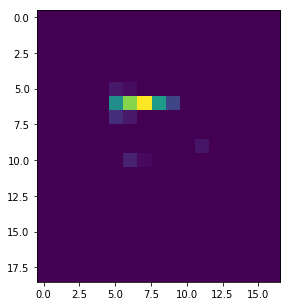

In [272]:
plt.figure(figsize=(5, 5))
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

color = 0
top, bottom, left, right = [5]*4
heatmap = cv2.copyMakeBorder(heatmap, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
plt.imshow(heatmap)
plt.imshow(heatmap)

In [273]:
os.chdir('/Users/RHedg/SFL Scientific Capstone/images/celeba')
img = cv2.imread('183976.jpg')

heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

heatmap = np.uint8(255 * heatmap)

heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed_img = heatmap * .4 + img

os.chdir('/Users/RHedg/DATA 2040')
cv2.imwrite('superimposed_attractive.jpg', superimposed_img)

True

In [18]:
os.getcwd()
os.chdir('/Users/RHedg/SFL Scientific Capstone/images')

In [28]:
img = image.load_img('rhedges_face.jpg', target_size=(218, 178))

In [27]:
img = np.rot90(img,-1)
x = image.img_to_array(img) / 255.0
x = np.expand_dims(x, axis=0) # add dimension to be able to fit into model
model.predict(x)

ValueError: Error when checking input: expected conv2d_44_input to have shape (218, 178, 3) but got array with shape (178, 218, 3)

In [6]:
preds = np.array([])
directory_attractive = '/Users/RHedg/SFL Scientific Capstone/images/celeba/'
for i in np.arange(5000):
    x = os.listdir(directory_attractive)[i+185000]
    img = image.load_img(directory_attractive+x, target_size=(218, 178))
    x = image.img_to_array(img) / 255.0
    x = np.expand_dims(x, axis=0) # add dimension to be able to fit into model
    pred = model.predict(x)
    preds = np.append(preds, pred)

In [31]:
len(preds)

5000

In [12]:
os.chdir('/Users/RHedg/SFL Scientific Capstone')
data_import = pd.read_table('list_attr_celeba.txt', delim_whitespace=True)
data = data_import.replace(-1, 0)
data['Beard'] = 1 - data['No_Beard']
data = data.drop('No_Beard', axis=1)

In [34]:
actual = data['Attractive'].values[185000:190000]

In [36]:
from sklearn.metrics import accuracy_score
1 - accuracy_score(np.round(preds),actual)

0.80359999999999998

In [44]:
predictions = pd.DataFrame(np.hstack((actual[:,np.newaxis],
                                      preds[:,np.newaxis])),
                           columns=['Class','Score'])

In [60]:
predictions['Class'] = (predictions['Class'] == 0) * 1

array([ 0.48454478,  0.56930369,  0.56144142, ...,  0.98957878,
        0.63807243,  0.92256635])

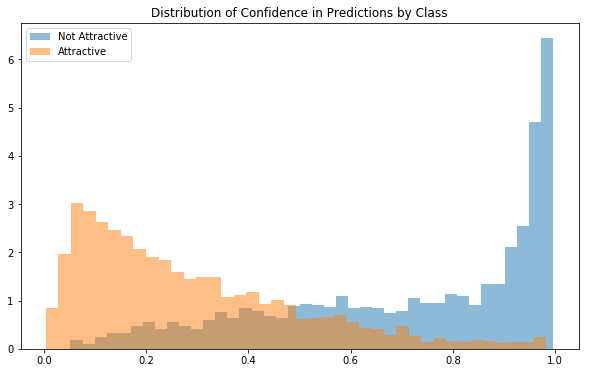

In [78]:
x1 = predictions['Score'][predictions['Class'] == 0].values
x2 = predictions['Score'][predictions['Class'] == 1].values

plt.figure(figsize=(10, 6))

kwargs = dict(histtype='stepfilled', alpha=.5, density=True, bins=40)
plt.title("Distribution of Confidence in Predictions by Class")
plt.hist(x1, **kwargs, label='Not Attractive')
plt.hist(x2, **kwargs, label='Attractive')
plt.legend(loc='upper left')
plt.show()
